# Image features and camera calibration

# Image features

First and foremost, for this lecture we need to install a different version of OpenCV, since the 'normal' version doesn't contain many features that we will need. Namely, the most popular **SIFT** features functionality was removed from OpenCV due to some copyright issues.

Thankfully, the functionality was not **completely** removed, it is still present in the downloadable OpenCV-sources and as such it is possible to assemble your own copy of the OpenCV libraries that still have all the cut functionality.

That, or we can just download a different package using `pip`. The package that we need is called `opencv-contrib-python`. Let's first uninstall the 'normal' package and install the new one:

## What are features

In computer vision it is often necessary to try to find a specific image, object or pattern on a larger image, either for object detection and tracking, or, for example, to stich together several smaller images.

To do that, we need to find specific patterns or specific features which are unique, which can be easily tracked, which can be easily compared. Let's consider this simple example:
![](https://docs.opencv.org/3.0-beta/_images/feature_simple.png)
We can see, that the blue patch is flat area and difficult to find and track. Wherever you move the blue patch, it looks the same. For black patch, it is an edge. If you move it in vertical direction (i.e. along the gradient) it changes. Put along the edge (parallel to edge), it looks the same. And for red patch, it is a corner. Wherever you move the patch, it looks different, means it is unique. So basically, corners are considered to be good features in an image. 

Here's a more complex real-life example:
![](https://docs.opencv.org/3.0-beta/_images/feature_building.jpg)
At the top of image, six small image patches are given. A and B are flat surfaces, and they are spread in a lot of area. It is difficult to find the exact location of these patches.

C and D are much more simpler. They are edges of the building. You can find an approximate location, but exact location is still difficult. It is because, along the edge, it is same everywhere. Normal to the edge, it is different. So edge is a much better feature compared to flat area, but not good enough (It is good in jigsaw puzzle for comparing continuity of edges).

Finally, E and F are some corners of the building. And they can be easily found out. Because at corners, wherever you move this patch, it will look different. So they can be considered as a good feature.

Finding these image features is called **Feature Detection**. Once we've found them, we can try to find the same features in the other images. We take a region around the feature and we search for the same area in other images. Basically, we are *describing the feature*. So called description is called **Feature Description**. Once we have the features and their description, we can find same features in all images and align them, stitch them or do whatever we want.

## Harris Corner Detector

We saw that corners are regions in the image with large variation in intensity in all the directions. One early attempt to find these corners is called **Harris Corner Detector**. See [this page](https://docs.opencv.org/3.1.0/dc/d0d/tutorial_py_features_harris.html) for a more detailed description.

OpenCV has the function `cv2.cornerHarris()` for this purpose. Its arguments are:
* `img` - Input image, it should be grayscale and float32 type.
* `blockSize` - It is the size of neighbourhood considered for corner detection
* `ksize` - Aperture parameter of Sobel derivative used.
* `k` - Harris detector free parameter in the equation.

See the example below:

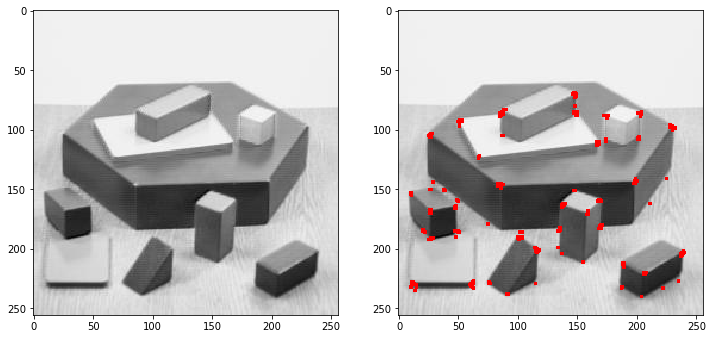

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread("blox.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# we need to convert the image to 32-bit floating point for the
# corner detector to work correctly
gray = np.float32(gray)

# extract features
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img_with_corners = np.copy(img)
img_with_corners[dst>0.01*dst.max()]=[0,0,255]

plt.subplots(figsize=(12, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img_with_corners,cv2.COLOR_BGR2RGB))
plt.show()

## Shi-Tomasi Corner Detector

A slight modification to the Harris Corner Detector is the **Shi-Tomasi Corner Detector**. 

OpenCV has a function, `cv2.goodFeaturesToTrack()`. It finds N strongest corners in the image by Shi-Tomasi method (or Harris Corner Detection, if we specify it). The input image should be a grayscale image. Then we specify number of corners we want to find. Then we specify the quality level, which is a value between 0-1, which denotes the minimum quality of corner below which everyone is rejected. Then we provide the minimum euclidean distance between corners detected.

With all these informations, the function finds corners in the image. All corners below quality level are rejected. Then it sorts the remaining corners based on quality in the descending order. Then function takes first strongest corner, throws away all the nearby corners in the range of minimum distance and returns N strongest corners.

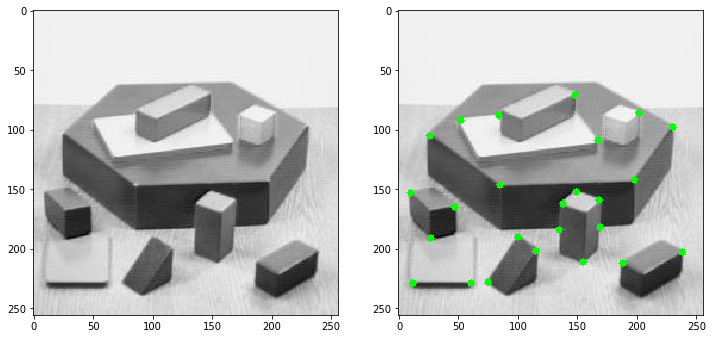

In [12]:
corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)

st_corners = np.copy(img)

for i in corners:
    x,y = i.ravel()
    cv2.circle(st_corners,(x,y),3,(0,255,),-1)

plt.subplots(figsize=(12, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(st_corners,cv2.COLOR_BGR2RGB))
plt.show()

## SIFT features

Harris and Shi-Tomasi corner features are rotation-invariant, which means, even if the image is rotated, we can find the same corners. It is obvious because corners remain corners in rotated image also. But what about scaling? A corner may not be a corner if the image is scaled.

That's why a new algorithm to detect and extract features was introduced: the **Scale-Invariant Feature Transform** (SIFT). Learn more about the theory behind the SIFT algorithm [here](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) or [here](http://aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/).

This is why we needed to install a different version of OpenCV. First we have to construct a SIFT object. We can pass different parameters to it which are optional and they are well explained in docs.

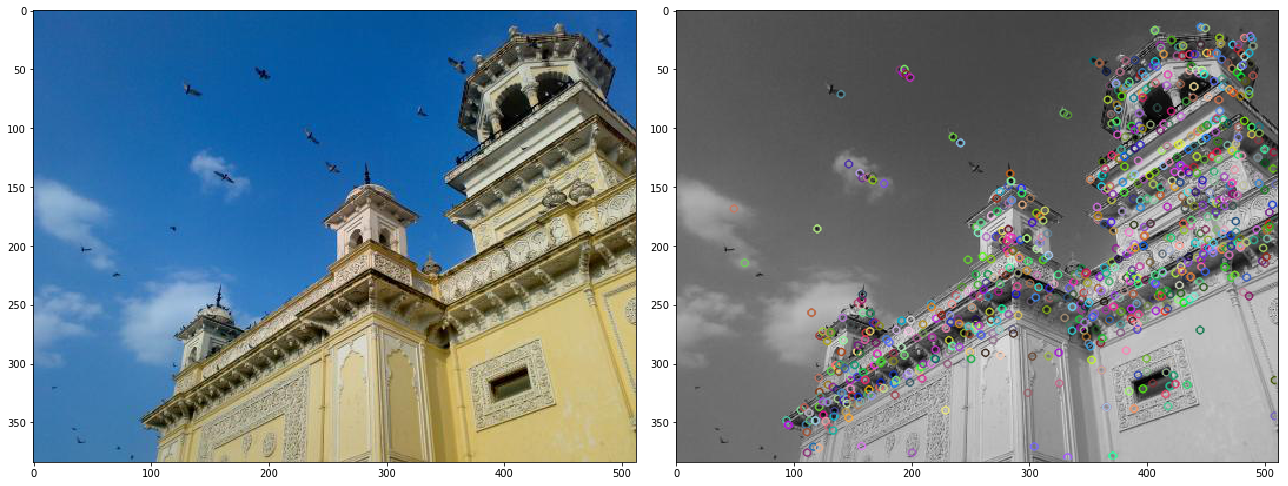

In [19]:
img = cv2.imread("home.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray, None)

# we can draw the detected keypoints on the image
mod_image = np.copy(img)
cv2.drawKeypoints(gray, kp, outImage=mod_image)

plt.subplots(figsize=(18, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(mod_image,cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

The `sift.detect()` function finds the keypoint in the images. We can pass a **mask** if we want to search only a part of image. Each keypoint is a special structure which has many attributes like its **(x,y)** coordinates, **size** of the meaningful neighbourhood, **angle** which specifies its orientation, response that specifies **strength** of keypoints, etc.

OpenCV also provides `cv2.drawKeyPoints()` function which draws the small circles on the locations of keypoints. If we pass a flag, `cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` to it, it will draw a circle with size of keypoint and it will even show its orientation. See below example:

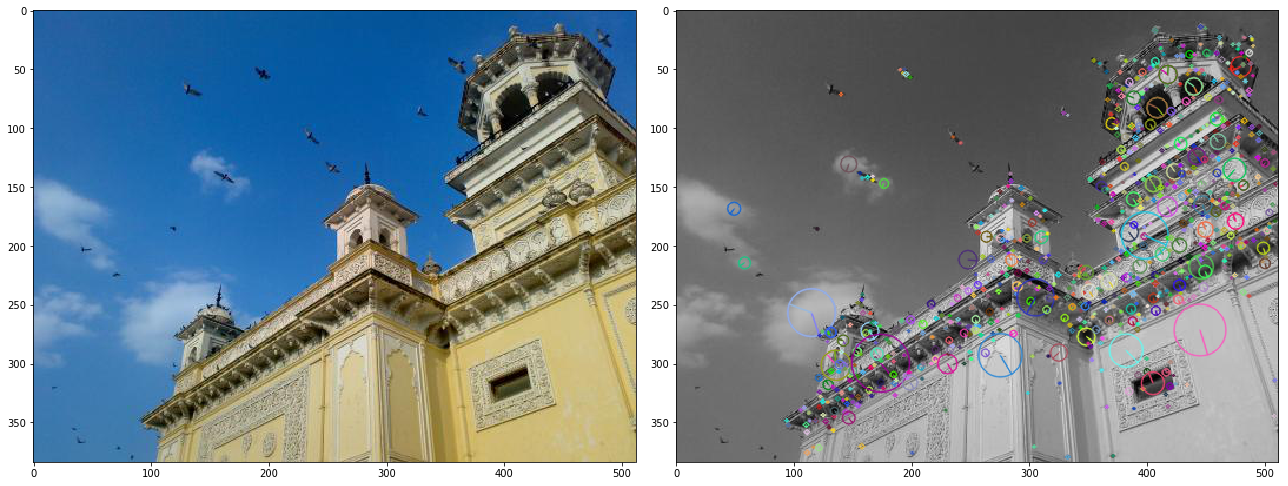

In [20]:
cv2.drawKeypoints(gray, kp, outImage=mod_image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplots(figsize=(18, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(mod_image,cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

Now to calculate the descriptor, OpenCV provides two methods.

1. Since we've already found keypoints, we can call `sift.compute()` which computes the descriptors from the keypoints we have found. Eg: `kp,des = sift.compute(gray,kp)`
2. If we didn't find keypoints, directly find keypoints and descriptors in a single step with the function, `sift.detectAndCompute()`.

We will see the second method:

In [21]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(gray, None)

Here **kp** will be a list of keypoints and **des** is a numpy array of shape $NumberOfKeypoints×128$.

## SURF Features

The SIFT algorithm for keypoint detection and description is comparatively slow and people needed more speeded-up version, which is why a newer and faster algorithm was introduced: **Speeded Up Robust Features** (SURF).

OpenCV provides SURF functionalities just like SIFT. We initiate a SURF object with some optional conditions like 64/128-dim descriptors, Upright/Normal SURF, etc. All the details are well explained in docs. Then as we did in SIFT, we can use SURF.detect(), SURF.compute(), etc. for finding keypoints and descriptors:

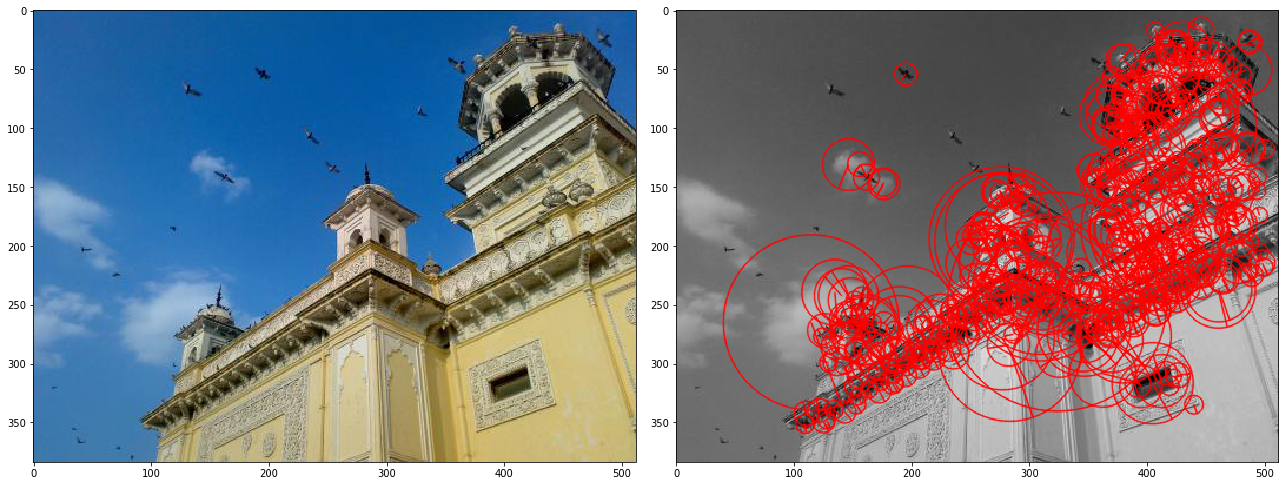

In [30]:
# Here we set Hessian Threshold to 1000
surf = cv2.xfeatures2d.SURF_create(1000)
kp, des = surf.detectAndCompute(gray,None)

img2=cv2.drawKeypoints(gray,kp,None,(0,0,255),4)

plt.subplots(figsize=(18, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

## ORB Features

The SIFT and SURF algorithms are patented and we are actually supposed to pay their developers for their use. A very good free alternative is the ORB algortithm (**Oriented FAST and Rotated BRIEF**).

ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. First it uses FAST to find keypoints, then applies Harris corner measure to find top N points among them. It also uses a pyramid to produce multiscale-features. Then the BRIEF algorithms is used to find descriptors.

As usual, we have to create an ORB object with the function, `cv2.ORB()` or using feature2d common interface. It has a number of optional parameters. Most useful ones are **nFeatures** which denotes maximum number of features to be retained (by default 500), **scoreType** which denotes whether Harris score or FAST score to rank the features (by default, Harris score) etc. Another parameter, **WTA_K** decides number of points that produce each element of the oriented BRIEF descriptor. By default it is two, i.e. selects two points at a time. In that case, for matching, `NORM_HAMMING` distance is used. If **WTA_K** is 3 or 4, which takes 3 or 4 points to produce BRIEF descriptor, then matching distance is defined by `NORM_HAMMING2`.

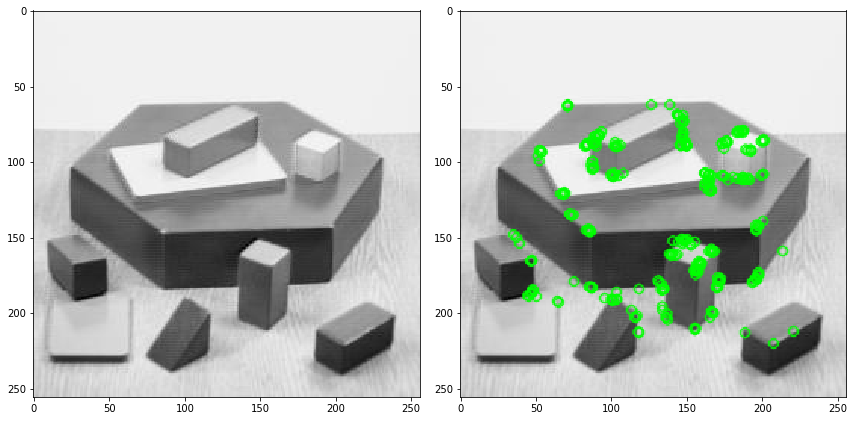

In [35]:
img = cv2.imread("blox.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# create the ORB object
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(gray,None)

# compute the descriptors with ORB
kp, des = orb.compute(gray, kp)

# draw only keypoints location,not size and orientation
img2 = np.copy(gray)
img2 = cv2.drawKeypoints(gray,kp,color=(0,255,0), flags=0, outImage=img2)

plt.subplots(figsize=(12, 10))
plt.subplot(121), plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()

# Feature Matching

Having computed the keypoints and the descriptors on one image we can then compute them on a different image and try to match them. If we manage to find a lot of the same-ish keypoints on two different images, it gives us a lot of important information. For instance it might mean, that the two images contain the same object. Or we can use the information to stich two pictures together (for example if we're trying to make a 360$^{\circ}$ picture).

The simplest way of matching features between two pictures is using the **Brute-Force matcher**. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

For BF matcher, first we have to create the BFMatcher object using `cv2.BFMatcher()`. It takes two optional parameters. First one is **normType**. It specifies the distance measurement to be used. By default, it is `cv2.NORM_L2`. It is good for SIFT, SURF, etc. (`cv2.NORM_L1` is also there). For binary string based descriptors like ORB, BRIEF, BRISK, etc., `cv2.NORM_HAMMING` should be used, which used Hamming distance as measurement. If ORB is using `WTA_K` == 3 or 4, `cv2.NORM_HAMMING2` should be used.

Second parameter is boolean variable, **crossCheck** which is *false* by default. If it is *true*, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. 

Once it is created, two important methods are `BFMatcher.match()` and `BFMatcher.knnMatch()`. First one returns the best match. Second method returns **k** best matches where k is specified by the user. It may be useful when we need to do additional work on that.

Like we used `cv2.drawKeypoints()` to draw keypoints, `cv2.drawMatches()` helps us to draw the matches. It stacks two images horizontally and draw lines from first image to second image showing best matches. There is also `cv2.drawMatchesKnn` which draws all the **k** best matches. If `k=2`, it will draw two match-lines for each keypoint. So we have to pass a mask if we want to selectively draw it.

Let's see an example with different feature types:

## Brute-Force Matching with ORB Descriptors

Here, we will see a simple example on how to match features between two images. In this case, we have a sample image that contains an object and a training image where we want to find the object. 

We are using ORB descriptors to match features. So let's start with loading images, finding descriptors, etc.

In [40]:
sample = cv2.imread("box.png", 0)
scene  = cv2.imread("box_in_scene.png", 0)

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(sample, None)
kp2, des2 = orb.detectAndCompute(scene,  None)

Next we create a BFMatcher object with distance measurement `cv2.NORM_HAMMING` (since we are using ORB) and `crossCheck` is switched on for better results. Then we use `Matcher.match()` method to get the best matches in two images. We sort them in ascending order of their distances so that best matches (with low distance) come to front. Then we draw only first 15 matches for the sake of better visibility.

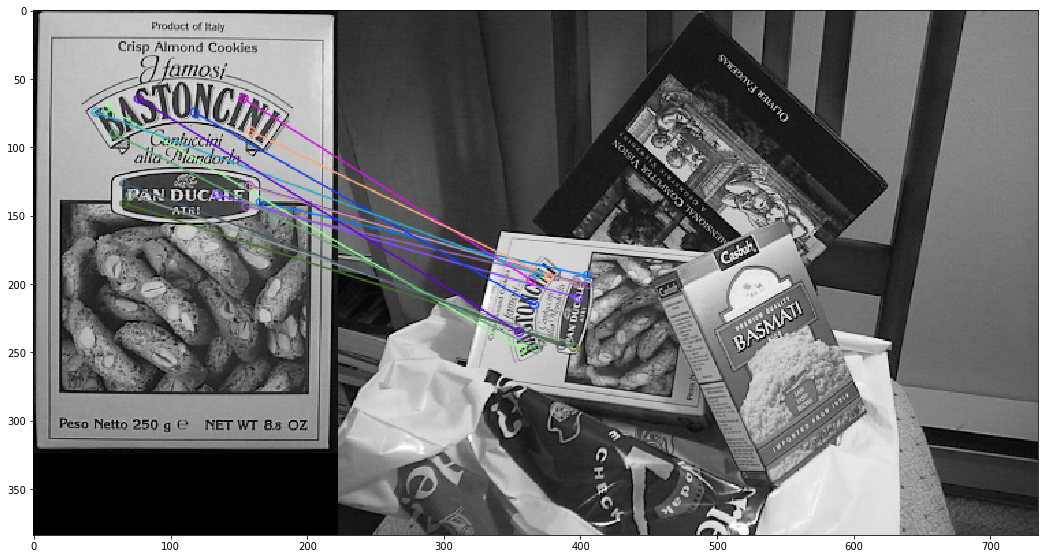

In [41]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
 
# Match descriptors.
matches = bf.match(des1,des2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 15 matches.
img3 = cv2.drawMatches(sample,kp1, scene,kp2, matches[:15], flags=2, outImg=None)

plt.subplots(figsize=(18, 10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

We can see that the same characteristic point were found both on the sample and on the training scene. 

The result of `matches = bf.match(des1,des2)` line is a list of DMatch objects. This DMatch object has following attributes:

* `DMatch.distance` - Distance between descriptors. The lower, the better it is.
* `DMatch.trainIdx` - Index of the descriptor in train descriptors
* `DMatch.queryIdx` - Index of the descriptor in query descriptors
* `DMatch.imgIdx` - Index of the train image.

## Brute-Force Matching with SIFT Descriptors

This time, we will use `BFMatcher.knnMatch()` to get **k** best matches. In this example, we will take k=2 so that we can apply ratio test.

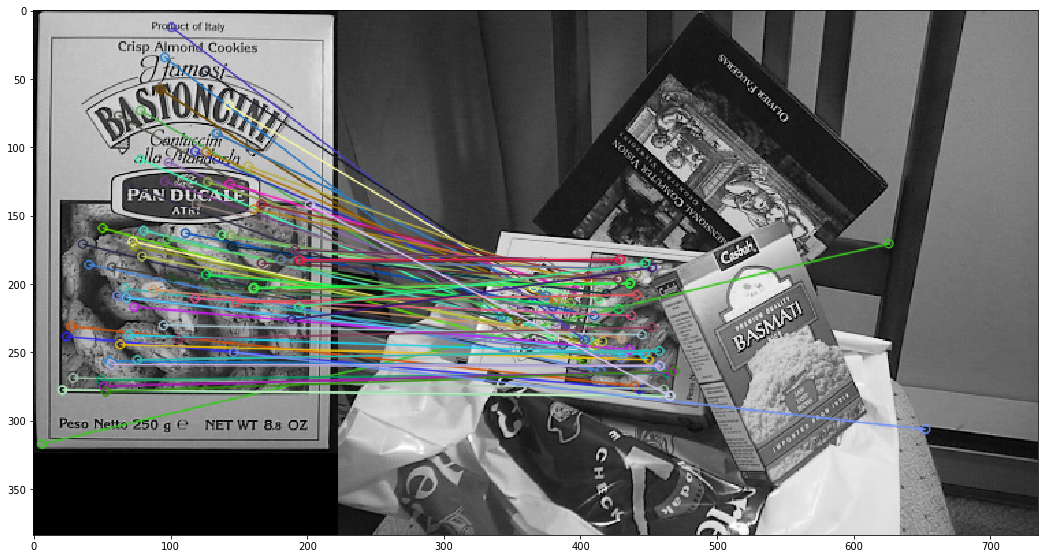

In [42]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(sample, None)
kp2, des2 = sift.detectAndCompute(scene, None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
 
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(sample,kp1, scene,kp2,good, flags=2, outImg=None) 

plt.subplots(figsize=(18, 10))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.show()

# Camera calibration

Today's cheap pinhole cameras introduces a lot of distortion to images. Two major distortions are **radial** distortion and **tangential** distortion.

Due to radial distortion, straight lines will appear curved. Its effect is more as we move away from the center of image. For example, one image is shown below, where two edges of a chess board are marked with red lines. But you can see that border is not a straight line and doesn't match with the red line. All the expected straight lines are bulged out.
![](https://docs.opencv.org/3.1.0/calib_radial.jpg)
Similarly, another distortion is the tangential distortion which occurs because image taking lense is not aligned perfectly parallel to the imaging plane. So some areas in image may look nearer than expected.

This chess pattern is perfect for the camera calibration, because we can easily see the parallel and perpendicular lines, as well as any present distortions.

So to find pattern in chess board, we use the function, `cv2.findChessboardCorners()`. We also need to pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid, etc.

Once we find the corners, we can increase their accuracy using `cv2.cornerSubPix()`. We can also draw the pattern using `cv2.drawChessboardCorners()`. All these steps are included in below code:

In [ ]:
import cv2
import numpy as np

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

cap = cv2.VideoCapture(0)

fnum = 1

while True:
    rt,img = cap.read()
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,6), corners, ret)
    
    cv2.imshow('img',img)
    
    key = cv2.waitKey(1) 
    if key == 27:
        break
    elif key & 0xFF == ord('s'):
        cv2.imwrite("chess_" + str(fnum) + ".jpg", img)
        fnum = fnum + 1
    elif key & 0xFF == ord('w'):
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)    

cap.release()
cv2.destroyAllWindows()

An example of what we'll see if we run the code:
![](chess_me.jpg)

So now we have our object points and image points we are ready to go for calibration. For that we use the function, `cv2.calibrateCamera()`. It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

### Undistortion

We have got what we were trying to get. Now we can take an image and undistort it. OpenCV comes with two methods for that. But before that, we can refine the camera matrix based on a free scaling parameter using `cv2.getOptimalNewCameraMatrix()`. If the scaling parameter `alpha=0`, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If `alpha=1`, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.

In [ ]:
h, w = img.shape[:2]
newcameramtx,roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

#### 1. Using cv2.undistort()

This is the shortest path. Just call the function and use ROI obtained above to crop the result:

In [ ]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

cv2.imshow('calibration result', dst)

#### 2. Using remapping

This is curved path. First find a mapping function from distorted image to undistorted image. Then use the remap function.

In [ ]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

cv2.imshow('calibration result', dst)

Both methods give the same result. The full code, that can be used for camera calibration is given below:

In [ ]:
import cv2
import numpy as np

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

cap = cv2.VideoCapture(0)

fnum = 1

undistorted = False

while True:
    rt,img = cap.read()    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    if not undistorted:
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (7,6), corners, ret)
    
    # if we don't have enough pbject points yet, display the old distorted image
    # but if we already have enough, we can calibrate the camera
    if len(imgpoints) >= 10:  
        # calibrate camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

        # get optimal camera matrix:
        h, w = img.shape[:2]
        newcameramtx,roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

        # undistort
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

        if undistorted is False:
            undistorted = True       
        
        # display the undistorted image
        cv2.imshow('calibrated image', dst)

    cv2.imshow('image', img)
    
    key = cv2.waitKey(1) 
    if key == 27:
        break
    elif key & 0xFF == ord('s'):
        cv2.imwrite("chess_" + str(fnum) + ".jpg", img)
        fnum = fnum + 1
    elif key & 0xFF == ord('w'):
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)   
            print "point saved" 

cap.release()
cv2.destroyAllWindows()

And here is an example of the results:
![](calibrated.png)
Now we can store the camera matrix and distortion coefficients using write functions in Numpy (np.savez, np.savetxt etc) for future uses.

Notice, that if the image from the camera was originally undistorted, it could happen that the undistortion process will yield an unsatisfactory result, even as far as actually **distorting** the image.